In [1]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt

from imutils import paths
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

In [2]:
#定義LBP演算法的函數
def lbp(img):
    assert(len(img.shape) == 2) # LBP只接受灰階影像
    ret = np.zeros_like(img)
    
    # 將圖片擴大，為了可以處理邊界
    img = cv.copyMakeBorder(img, 1, 1, 1, 1, cv.BORDER_REPLICATE)
    
    for y in range(1, img.shape[0] - 1):
        for x in range(1, img.shape[1] - 1):
            center = img[y][x]
            pixel = 0
            pixel |= (img[y - 1][x - 1] >= center) << 0
            pixel |= (img[y - 1][x + 0] >= center) << 1
            pixel |= (img[y - 1][x + 1] >= center) << 2
            pixel |= (img[y + 0][x + 1] >= center) << 3
            pixel |= (img[y + 1][x + 1] >= center) << 4
            pixel |= (img[y + 1][x + 0] >= center) << 5
            pixel |= (img[y + 1][x - 1] >= center) << 6
            pixel |= (img[y + 0][x - 1] >= center) << 7
            
            ret[y-1][x-1] = pixel
    return ret

In [3]:
#讀取經LBP處理圖像之位址
imagePaths_train = sorted(list(paths.list_images(".\\Face_LBP_histogram\\train")))
imagePaths_test = sorted(list(paths.list_images(".\\Face_LBP_histogram\\test")))

train_feature = []
train_label = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4]
test_feature = []
test_label = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]

for imagePath in imagePaths_train:
    img = cv.imread(imagePath)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # 將影像轉為灰階
    lbpImage = lbp(gray)
    
    #計算直方圖
    hist = cv.calcHist([lbpImage], [0], None, [256], [0, 256])
    train_feature.append(hist)
for imagePath in imagePaths_test:
    img = cv.imread(imagePath)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # 將影像轉為灰階
    lbpImage = lbp(gray)
    
    #計算直方圖
    hist = cv.calcHist([lbpImage], [0], None, [256], [0, 256])
    test_feature.append(hist)

In [4]:
train_feature = np.array(train_feature, dtype="float")
test_feature = np.array(test_feature, dtype="float")
train_label = np.array(train_label)
test_label = np.array(test_label)

train_feature = np.reshape(train_feature, (40, 256))
test_feature = np.reshape(test_feature, (10, 256))

print("Train Data shape:" + str(train_feature.shape))
print("Test Data shape:" + str(test_feature.shape))
print("Train Label shape:" + str(train_label.shape))
print("Test Label shape:" + str(test_label.shape))

Train Data shape:(40, 256)
Test Data shape:(10, 256)
Train Label shape:(40,)
Test Label shape:(10,)


In [5]:
print(train_feature)
print(train_feature.shape)

[[ 867.  107.  356. ...  282.  135. 1149.]
 [ 860.  115.  345. ...  301.  108. 1121.]
 [ 974.  114.  338. ...  310.  124. 1177.]
 ...
 [ 900.  108.  324. ...  277.  112. 1153.]
 [ 855.  106.  419. ...  318.  120. 1124.]
 [ 868.  117.  368. ...  340.  127. 1133.]]
(40, 256)


In [6]:
#label 轉換為 One-Hot Encoding 編碼
train_label_onehot = to_categorical(train_label)
test_label_onehot = to_categorical(test_label)
print(test_label_onehot)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [7]:
#建立模型
model = Sequential()
#輸入層：256, 隱藏層：25，輸出層：5
model.add(Dense(units=50, 
                input_dim=256, 
                kernel_initializer='normal', 
                activation='relu'))
model.add(Dense(units=25,  
                kernel_initializer='normal', 
                activation='relu'))
model.add(Dense(units=5, 
                kernel_initializer='normal', 
                activation='softmax'))
model.summary()  # 模型可視化


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                12850     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 5)                 130       
                                                                 
Total params: 14255 (55.68 KB)
Trainable params: 14255 (55.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
#定義訓練方式
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

#以(train_feature_normalize,train_label_onehot)資料訓練
train_history =model.fit(x=train_feature,
                         y=train_label_onehot,validation_split=0.2, 
                         epochs=20, batch_size=4,verbose=2)

Epoch 1/20


8/8 - 1s - loss: 2.2175 - accuracy: 0.2188 - val_loss: 1.8764 - val_accuracy: 0.0000e+00 - 601ms/epoch - 75ms/step
Epoch 2/20
8/8 - 0s - loss: 1.6022 - accuracy: 0.1562 - val_loss: 3.0035 - val_accuracy: 0.0000e+00 - 28ms/epoch - 4ms/step
Epoch 3/20
8/8 - 0s - loss: 1.4377 - accuracy: 0.2188 - val_loss: 3.7679 - val_accuracy: 0.0000e+00 - 33ms/epoch - 4ms/step
Epoch 4/20
8/8 - 0s - loss: 1.4662 - accuracy: 0.3125 - val_loss: 4.5595 - val_accuracy: 0.0000e+00 - 31ms/epoch - 4ms/step
Epoch 5/20
8/8 - 0s - loss: 1.4159 - accuracy: 0.2812 - val_loss: 5.0138 - val_accuracy: 0.0000e+00 - 32ms/epoch - 4ms/step
Epoch 6/20
8/8 - 0s - loss: 1.3220 - accuracy: 0.3438 - val_loss: 5.1508 - val_accuracy: 0.0000e+00 - 37ms/epoch - 5ms/step
Epoch 7/20
8/8 - 0s - loss: 1.3001 - accuracy: 0.4375 - val_loss: 5.3924 - val_accuracy: 0.0000e+00 - 43ms/epoch - 5ms/step
Epoch 8/20
8/8 - 0s - loss: 1.2953 - accuracy: 0.5000 - val_loss: 5.6299 - val_accuracy: 0.0000e+00 - 32ms/epoch - 4ms/step
Epoc

In [9]:
#評估準確率
scores = model.evaluate(test_feature, test_label_onehot)
print('\n準確率=',scores[1])

1/1 [==============================] - 0s 129ms/step - loss: 2.3414 - accuracy: 0.4000

準確率= 0.4000000059604645


In [10]:
predict=model.predict(test_feature)
prediction=np.argmax(predict,axis=1)

1/1 [==============================] - 0s 68ms/step


In [11]:
print(np.argmax(predict, axis=1))

[0 0 1 1 3 3 1 1 1 1]


In [12]:
test_path = sorted(list(paths.list_images(".\\Face_LBP_histogram\\test")))
test = []

for imagePath in test_path:
    print(imagePath)
    # load the image, pre-process it, and store it in the data list
    image = cv.imread(imagePath)
    image = img_to_array(image)
    test.append(image)
test = np.array(test, dtype="float")
test = test/255

.\Face_LBP_histogram\test\0.jpg
.\Face_LBP_histogram\test\01.jpg
.\Face_LBP_histogram\test\02.jpg
.\Face_LBP_histogram\test\03.jpg
.\Face_LBP_histogram\test\04.jpg
.\Face_LBP_histogram\test\05.jpg
.\Face_LBP_histogram\test\06.jpg
.\Face_LBP_histogram\test\07.jpg
.\Face_LBP_histogram\test\08.jpg
.\Face_LBP_histogram\test\09.jpg


In [13]:
# 顯示圖片及預測結果的函數
import random

def plot_images_labels_prediction(images, labels, prediction=[], names=[], predictions_array=[], num=20):
    # 取得 pyplot 物件參考
    fig = plt.gcf()

    # 設定畫布大小為 12 吋*14吋
    fig.set_size_inches(12, 14)

    idx = random.randint(0, images.shape[0] - 1)

    # 限制最多顯示 20 個子圖
    if num > 20: num = 20

    # 依序顯示 num 個子圖
    for i in range(0, num):
        # 建立 5*5 個子圖中的第 i+1 個 
        ax = plt.subplot(5, 5, i + 1)

        # 顯示子圖
        ax.imshow(images[idx], cmap='gray')

        title = ""
        color = 'black'
        label = labels[idx]
        pred = None

        # 有預測值就加入標題中
        if len(prediction) > 0:
            if prediction[idx] != labels[idx]:
                color = 'red'
                confidence = 100 * np.min(predictions_array[idx])
            else:
                color = 'blue'
                confidence = 100 * np.max(predictions_array[idx])
            pred = prediction[idx]
        
        if len(names) > 0:
            # print(names)
            # print(label)
            label = names[label]
            if pred != None:
                pred = names[pred]

        title = "label = " + str(label)
        if pred != None: title += "\npredict = " + str(pred)

        title = "{}\nscore={:2.2f}%".format(title, confidence)

        # 設定標題
        ax.set_title(title, fontsize=10, color=color) 
        
        # 不顯示 x 、y軸刻度
        ax.set_xticks([]);  
        ax.set_yticks([]);
        
        # 樣本序號增量 1
        idx += 1    
        if idx >= images.shape[0]:
            idx = 0
    
    # 繪製圖形
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
    plt.show()

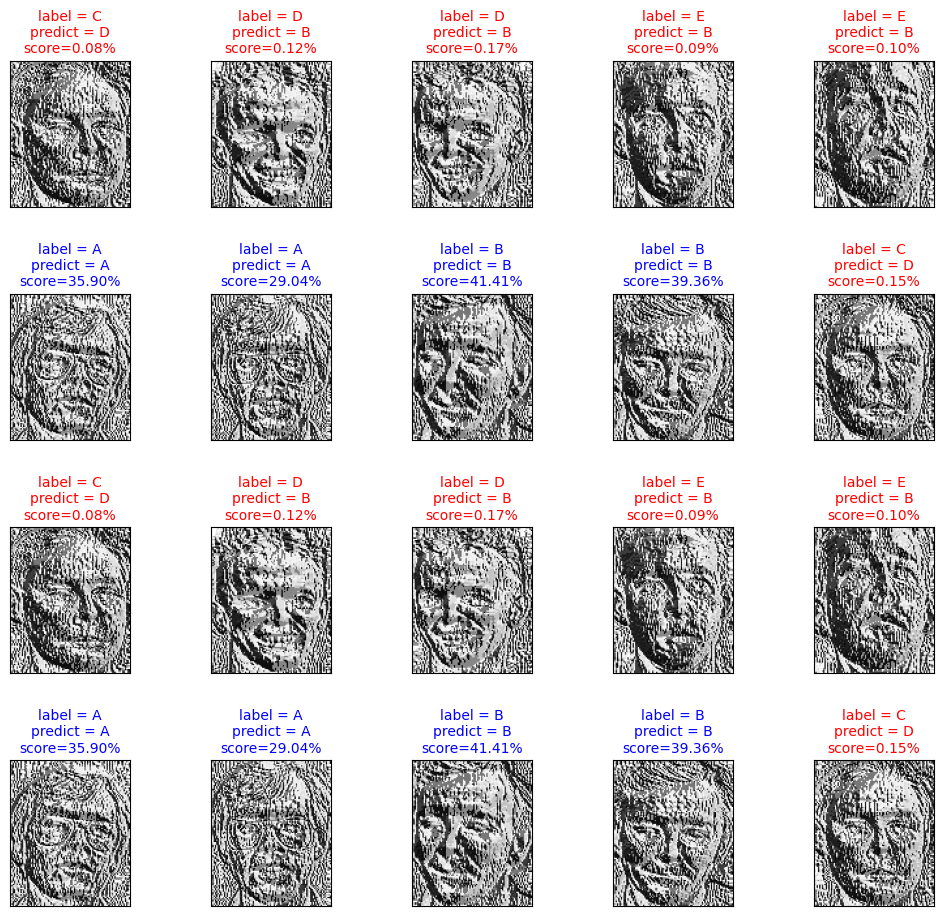

In [14]:
NAMES = ['A', 'B', 'C', 'D', 'E']
plot_images_labels_prediction(test, np.argmax(test_label_onehot, axis=1), np.argmax(predict, axis=1), NAMES, predictions_array=predict)